In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd

In [6]:
data_dir = "../data"
sc_counts = ad.read_h5ad(f'{data_dir}/sc_counts_leiden.h5ad')

In [7]:
# remove cluster 17 and three compounds:
# CEP-18770 (Delanzomib), MLN 2238, Oprozomib (ONX 0912) 

In [8]:
sc_counts = sc_counts[(sc_counts.obs.leiden_res1 != "17") & ~sc_counts.obs.sm_name.isin(["CEP-18770 (Delanzomib)", "MLN 2238", "Oprozomib (ONX 0912)"])]

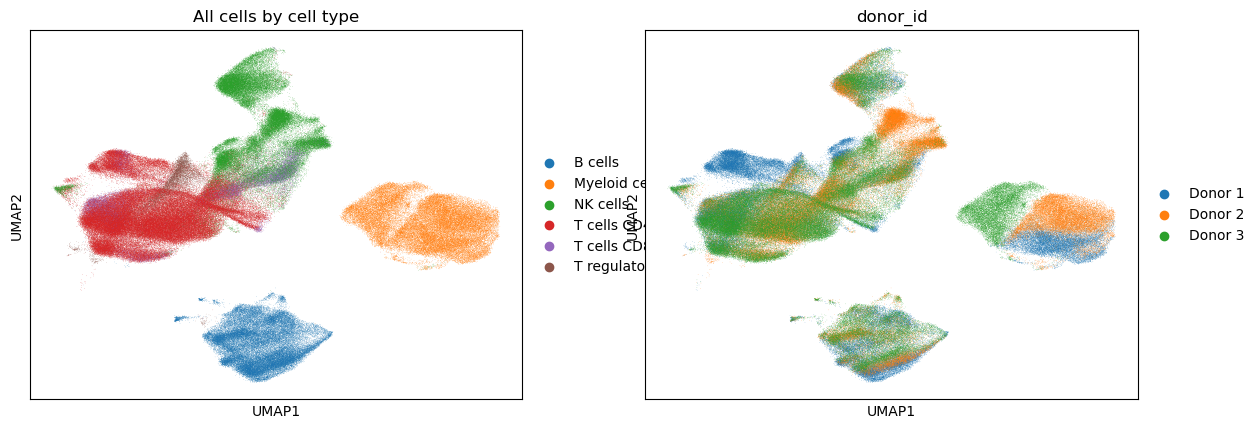

In [9]:
sc.pl.umap(sc_counts, color=['cell_type', 'donor_id'], title="All cells by cell type")

In [10]:
# add celltypist annotation to the dataset
import celltypist
from celltypist import models

In [25]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [26]:
predictions = celltypist.annotate(sc_counts, model = model, majority_voting = True)

🔬 Input data has 298290 cells and 21265 genes
🔗 Matching reference genes in the model
🧬 5548 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [27]:
from collections import defaultdict

mapping = {
    'B cells': 'B cells',
    'Plasma cells': 'B cells',
    'B-cell lineage': 'B cells',
    'T cells': 'T cells',
    'Double-positive thymocytes': 'T cells',
    'Macrophages': 'Myeloid cells',
    'DC': 'Myeloid cells',
    'Monocytes': 'Myeloid cells',
    'Mono-mac': 'Myeloid cells',
    'Myelocytes': 'Myeloid cells',
    'pDC': 'Myeloid cells',
    'Monocyte precursor': 'Myeloid cells',
    'Early MK': 'Myeloid cells',
    'Erythrocytes': 'Myeloid cells',
    'Erythroid': 'Myeloid cells',
    'DC precursor': 'Myeloid cells',
    'pDC precursor': 'Myeloid cells',
    'Megakaryocyte precursor': 'Myeloid cells',
    'Mast cells': 'Myeloid cells',
    'ILC': 'NK cells',
    'ILC precursor': 'NK cells',
    # Additional or exceptional mappings
    'HSC/MPP': 'Other',  # You might categorize differently or exclude
    'Cycling cells': 'Other',  # or based on additional context
    'Epithelial cells': 'Other',  # not part of the immune classification
}
reverse_mapping = defaultdict(list)

# Populate the reverse mapping dictionary
for cell_type, category in mapping.items():
    reverse_mapping[category].append(cell_type)

# Convert defaultdict to a regular dictionary for easier use later
reverse_mapping = dict(reverse_mapping)

# Example of what is in the reverse mapping
for category, types in reverse_mapping.items():
    print(f"{category}: {types}")

B cells: ['B cells', 'Plasma cells', 'B-cell lineage']
T cells: ['T cells', 'Double-positive thymocytes']
Myeloid cells: ['Macrophages', 'DC', 'Monocytes', 'Mono-mac', 'Myelocytes', 'pDC', 'Monocyte precursor', 'Early MK', 'Erythrocytes', 'Erythroid', 'DC precursor', 'pDC precursor', 'Megakaryocyte precursor', 'Mast cells']
NK cells: ['ILC', 'ILC precursor']
Other: ['HSC/MPP', 'Cycling cells', 'Epithelial cells']


In [28]:
# apply reverse mapping dict to 
sc_counts.obs["celltypist_celltype"] = predictions.predicted_labels.predicted_labels
sc_counts.obs['celltypist_celltype'] = sc_counts.obs['celltypist_celltype'].map(mapping).fillna('Other')

In [30]:
sc_counts_hvg = sc_counts[:, sc_counts.var.highly_variable]

In [31]:
sc_counts_hvg_donor1 = sc_counts_hvg[sc_counts_hvg.obs.donor_id == "Donor 1"]
sc_counts_hvg_donor2 = sc_counts_hvg[sc_counts_hvg.obs.donor_id == "Donor 2"]
sc_counts_hvg_donor3 = sc_counts_hvg[sc_counts_hvg.obs.donor_id == "Donor 3"]

In [33]:
del sc_counts_hvg_donor1.obsp, sc_counts_hvg_donor2.obsp, sc_counts_hvg_donor3.obsp
del sc_counts_hvg_donor1.obsm["X_pca"], sc_counts_hvg_donor2.obsm["X_pca"], sc_counts_hvg_donor3.obsm["X_pca"]
del sc_counts_hvg_donor1.obsm["X_umap"], sc_counts_hvg_donor2.obsm["X_umap"], sc_counts_hvg_donor3.obsm["X_umap"]

In [35]:
sc.pp.neighbors(sc_counts_hvg_donor1)
sc.tl.leiden(sc_counts_hvg_donor1, key_added="leiden_res1_donor1", resolution=1.0)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [36]:
sc.pp.neighbors(sc_counts_hvg_donor2)
sc.tl.leiden(sc_counts_hvg_donor2, key_added="leiden_res1_donor2", resolution=1.0)
sc.pp.neighbors(sc_counts_hvg_donor3)
sc.tl.leiden(sc_counts_hvg_donor3, key_added="leiden_res1_donor3", resolution=1.0)

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


In [40]:
sc.tl.umap(sc_counts_hvg_donor1)
sc.tl.umap(sc_counts_hvg_donor2)
sc.tl.umap(sc_counts_hvg_donor3)

In [37]:
from matplotlib import pyplot as plt

def plot_marker_expression(adata, markers, groupby):
    """
    This function plots the expression of given markers across specified groups (e.g., cell types).
    
    Parameters:
        adata (AnnData): The annotated data matrix of shape (n_obs, n_vars). Rows correspond to cells and columns to genes.
        markers (dict): A dictionary where keys are the cell types and values are lists of markers associated with each cell type.
        groupby (str): The key in adata.obs that corresponds to the grouping variable (e.g., predicted cell type).
    """
    # Initialize the figure
    num_types = len(markers)
    fig, axs = plt.subplots(1, num_types, figsize=(5*num_types, 5), squeeze=False)

    for i, (cell_type, marker_list) in enumerate(markers.items()):
        # Filter data for the markers of the current cell type
        sc.pl.dotplot(adata, var_names=marker_list, groupby=groupby, ax=axs[0, i], show=False)
        axs[0, i].set_title(f'{cell_type} Markers')

    plt.tight_layout()
    plt.show()

# CD3, CD8, CD19, CD56, CD11c, TCRgd, CD123 identified in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9905713/
# markers from https://sctype.app/database.php and Yoshida2022
markers_t_nk = {
    'NK': [
        "NCAM1",
        "KLRB1",
        "NCR1",
    "CD2",
    "CD69",
    "NKG7",
    "GZMB",
    "GZMA",
    "GZMM",
    "FCGR3A",
    "GNLY",
    "COX6A2",
    "ZMAT4",
    "KIR2DL4",
    "NKG7"],
    'T cells': [    "CD2",
                    "CD8A",
                    "CD4",
    "CD3D",
    "CD3E",
    "CD3G",
    "CD27",
    "FOXP3",
    "CCR7",
    "CCR6",
    "CD6",
    "CTLA4",
    "IL2RA",
    "GZMB",
    "PTPRC",
    "TRDV2",
    "TRGV9",
    "TRGC1",
    ],
    "B cells": [
            "CD19",
    "CD27",
    "CD38",
    "CD24",
    "MS4A1",
    "PTPRC",
    "PAX5",
    "CD24",
    "CD38",
    "CD79A",
    "JCHAIN",
    "SSR4",
    "FKBP11",
    "SEC11C",
    "DERL3",
    "PRDX4",
    "IGLL5",
    "CD79B",
    "TCL1A",
    "IGLL5",
    "HLA-DQA1",
    "HLA-DQB1",
    "CD38",
    "VPREB3",
    "IGLL5"
    ],
    "Myeloid cells": [
        "ITGAX",
        "CD14",
        "CD68",
        "CD163",
        "CD83",
        "CD1C"
    ]
}

... storing 'celltypist_celltype' as categorical


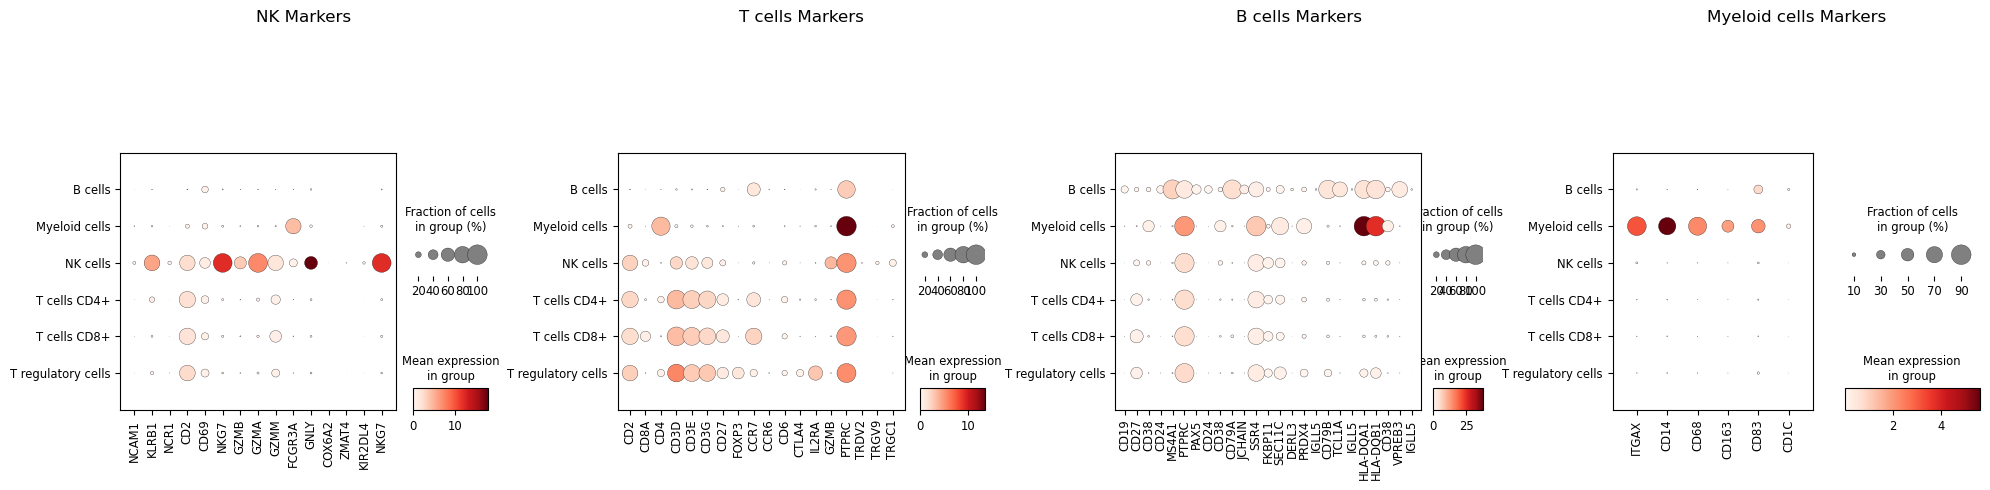

In [38]:
plot_marker_expression(sc_counts_hvg_donor1, markers_t_nk, "cell_type")

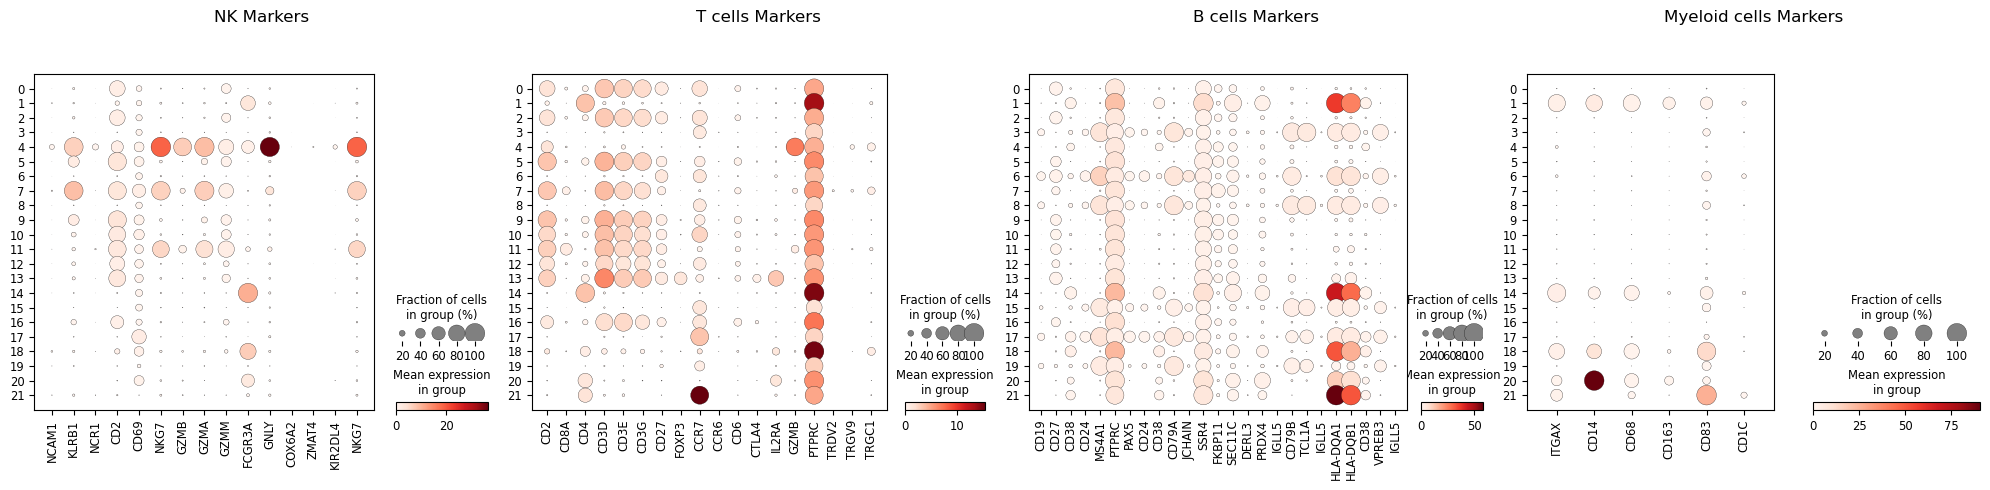

In [39]:
plot_marker_expression(sc_counts_hvg_donor1, markers_t_nk, "leiden_res1_donor1")

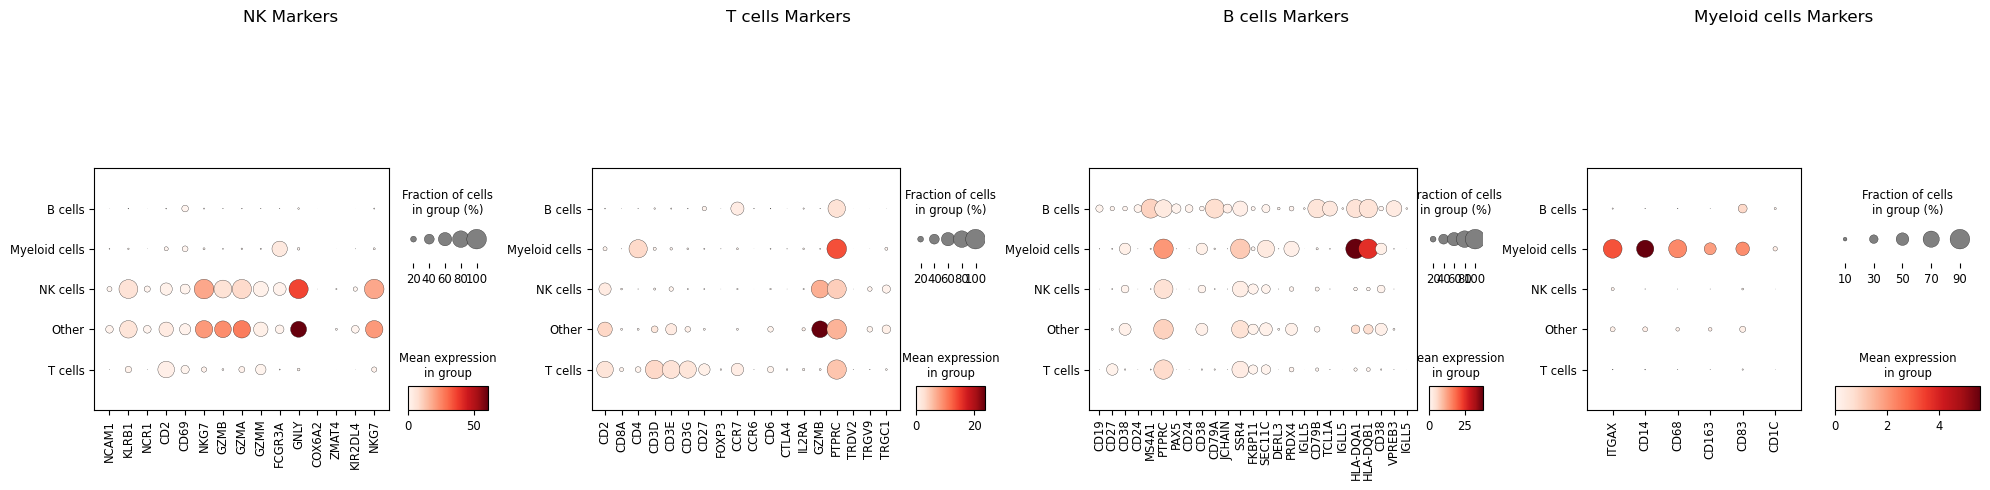

In [41]:
plot_marker_expression(sc_counts_hvg_donor1, markers_t_nk, "celltypist_celltype")

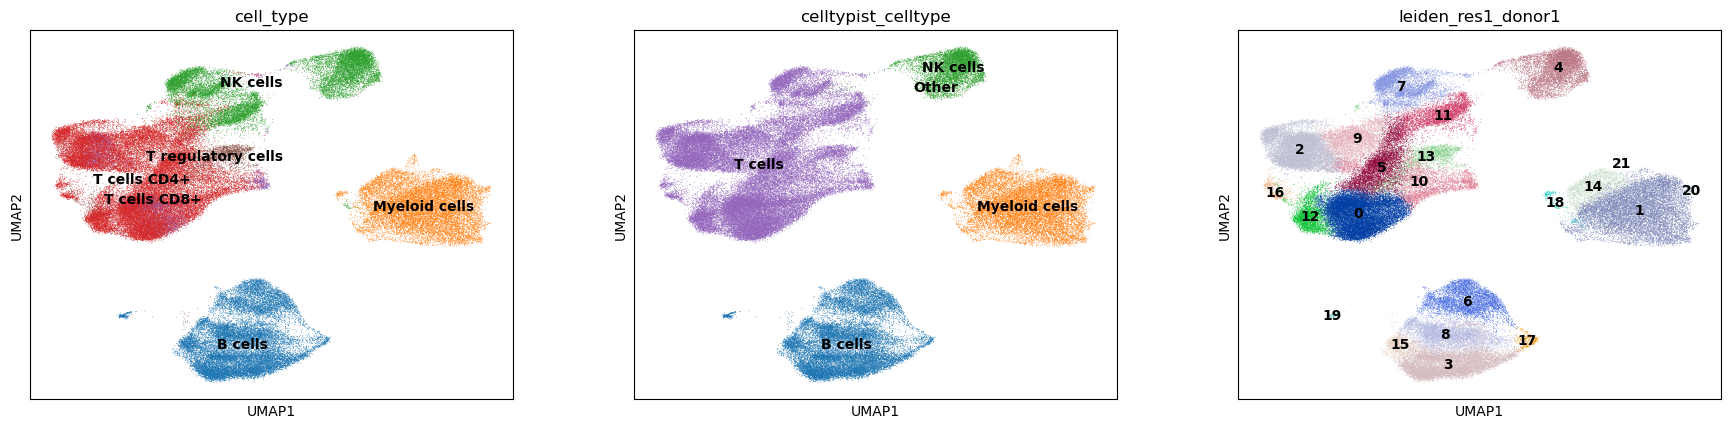

In [44]:
sc.pl.umap(sc_counts_hvg_donor1, color=['cell_type', "celltypist_celltype", "leiden_res1_donor1"], legend_loc="on data")

In [ ]:
# we take leiden clusters per donor as the ground truth
# for B cells, according to CD19 marker, 3, 6, 8, 15, 17, 19 are good candidates
# similarly MS4A1, CD79A, and PAX9 (last is the least prominent in cluster 19)

# for Myeloid cells, clusters 1, 20, 21, 14, 18 are good candidates
# especially due to ITGAX and CD68

# for NK cells, cluster 4 is a clear candidate due to NCAM1 and NCR1 expression
# cluster 11 has some KIR2DL4 and NCR1 expression that makes it a candidate as well

# 0, 2, 5, 7, 9, 10, 11, 12, 13, 16 are all candidates for T ells, especially due to CD2, CD3D, CD3E, CD3G
# To differentiate between NK and T cells, we look into both celltypist  and original annotation proportions in the clusters for which we are uncertain

In [50]:
def calculate_category_proportions(adata, leiden_cluster):
    """
    Calculate the proportions of non-zero categories for 'cell_type' and 'celltypist_celltype'
    within a specified Leiden cluster from an anndata object.

    Parameters:
    adata (anndata.AnnData): The annotated data matrix.
    leiden_cluster (str): The Leiden cluster number.

    Returns:
    dict: A dictionary containing the proportions of each category in 'cell_type' and 'celltypist_celltype'.
    """
    # Filter the data to include only cells from the specified Leiden cluster
    filtered_data = adata.obs[adata.obs['leiden_res1_donor1'] == leiden_cluster]
    
    # Calculate the proportions for 'cell_type'
    cell_type_counts = filtered_data['cell_type'].value_counts()
    cell_type_proportions = cell_type_counts / cell_type_counts.sum()
    
    # Calculate the proportions for 'celltypist_celltype'
    celltypist_counts = filtered_data['celltypist_celltype'].value_counts()
    celltypist_proportions = celltypist_counts / celltypist_counts.sum()
    
    # Return results as a dictionary
    return {
        'cell_type_proportions': cell_type_proportions,
        'celltypist_celltype_proportions': celltypist_proportions
    }

In [51]:
calculate_category_proportions(sc_counts_hvg_donor1, "4")

{'cell_type_proportions': cell_type
 NK cells              0.993976
 T cells CD8+          0.003244
 T regulatory cells    0.001854
 T cells CD4+          0.000772
 Myeloid cells         0.000154
 B cells               0.000000
 Name: count, dtype: float64,
 'celltypist_celltype_proportions': celltypist_celltype
 NK cells         0.992895
 T cells          0.004479
 Other            0.002317
 Myeloid cells    0.000309
 B cells          0.000000
 Name: count, dtype: float64}

In [52]:
calculate_category_proportions(sc_counts_hvg_donor1, "7")

{'cell_type_proportions': cell_type
 NK cells              0.910291
 T cells CD4+          0.082904
 T cells CD8+          0.006599
 T regulatory cells    0.000206
 B cells               0.000000
 Myeloid cells         0.000000
 Name: count, dtype: float64,
 'celltypist_celltype_proportions': celltypist_celltype
 T cells          0.988451
 NK cells         0.010930
 Other            0.000619
 B cells          0.000000
 Myeloid cells    0.000000
 Name: count, dtype: float64}

In [53]:
calculate_category_proportions(sc_counts_hvg_donor1, "11")

{'cell_type_proportions': cell_type
 NK cells              0.828385
 T cells CD4+          0.161458
 T cells CD8+          0.009115
 T regulatory cells    0.001042
 B cells               0.000000
 Myeloid cells         0.000000
 Name: count, dtype: float64,
 'celltypist_celltype_proportions': celltypist_celltype
 T cells          0.997135
 NK cells         0.002865
 B cells          0.000000
 Myeloid cells    0.000000
 Other            0.000000
 Name: count, dtype: float64}

In [125]:
def find_sm_proportions_in_clusters(adata, leiden_clusters, donor=1):
    """
    Calculate and return a sorted dataframe of the 'sm_name' categories based on their proportions
    of cells from specific Leiden clusters compared to the total cells of each 'sm_name' category
    in the entire dataset.

    Parameters:
    adata (anndata.AnnData): The annotated data matrix.
    leiden_clusters (list): A list of Leiden cluster numbers.

    Returns:
    DataFrame: A dataframe with 'sm_name' categories and their proportions sorted from smallest to largest.
    """
    # Filter the data to include only cells from the specified Leiden clusters
    filtered_data = adata.obs[adata.obs[f'leiden_res1_donor{donor}'].isin(leiden_clusters)]
    
    # Calculate the counts of 'sm_name' in the filtered data
    sm_name_in_clusters_counts = filtered_data['sm_name'].value_counts()
    
    # Calculate the total counts of 'sm_name' in the entire dataset
    total_sm_name_counts = adata.obs['sm_name'].value_counts()
    
    # Calculate the proportions
    sm_name_proportions = sm_name_in_clusters_counts / total_sm_name_counts
    
    # Create a dataframe of the results
    proportions_df = sm_name_proportions.reset_index()
    proportions_df.columns = ['sm_name', 'proportion']
    
    # Sort the dataframe by proportion from smallest to largest
    proportions_df = proportions_df.sort_values(by='proportion')

    return proportions_df


In [126]:
def find_dmso_proportions_in_clusters(adata, leiden_clusters, donor=1):
    """
    Calculate and return a sorted dataframe of the 'sm_name' categories based on their proportions
    within a specified group of Leiden clusters, specifically for cells with 'sm_name' as 'DMSO'.

    Parameters:
    adata (anndata.AnnData): The annotated data matrix.
    leiden_clusters (list): A list of Leiden cluster numbers.

    Returns:
    DataFrame: A dataframe with 'sm_name' categories and their proportions sorted from smallest to largest.
    """
    proportions_df = find_sm_proportions_in_clusters(adata, leiden_clusters, donor)
    return proportions_df[proportions_df['sm_name'] == 'Dimethyl Sulfoxide']

In [138]:
find_sm_proportions_in_clusters(sc_counts_hvg_donor1, ["4", "7", "11"])

sm_name  proportion
66                              IN1451    0.046647
106                               R428    0.105042
103  Proscillaridin A;Proscillaridin-A    0.109955
138                    UNII-BXU45ZH6LI    0.111111
105                        Quizartinib    0.114887
..                                 ...         ...
124                          Sunitinib    0.209677
87                           Nilotinib    0.216920
89                             OSI-930    0.221790
1                               ABT737    0.235741
20                          BMS-387032    0.537815

[144 rows x 2 columns]

In [133]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor1, ["4", "7", "11"])

sm_name  proportion
48  Dimethyl Sulfoxide    0.163712

In [129]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor1, ["4"])

sm_name  proportion
48  Dimethyl Sulfoxide    0.068082

In [136]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor1, ['0', '2', '5', '7', '9', '10', '11', '12', '13', '16'])

sm_name  proportion
48  Dimethyl Sulfoxide    0.530202

array([[<Axes: title={'center': 'proportion'}>]], dtype=object)

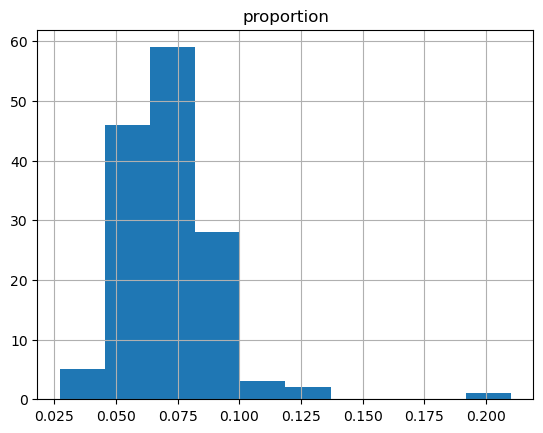

In [131]:
find_sm_proportions_in_clusters(sc_counts_hvg_donor1, ["4"]).hist()

In [79]:
# we conclude that there are 3 outliers in terms of low fraction of NK cells and that doesn't change depending on including 7 and 11 as NK, so we leave only cluster 4 as NK cells. Especially given that the proportion of NK in DMSO doesn't depend heavily on the choice

In [90]:
def assign_cell_types_based_on_leiden(adata, leiden_to_celltype_map, donor=1):
    """
    Assign new cell types to cells in an anndata object based on a dictionary mapping
    Leiden clusters to cell type categories.

    Parameters:
    adata (anndata.AnnData): The annotated data matrix.
    leiden_to_celltype_map (dict): A dictionary where keys are cell type categories and values
                                   are lists of Leiden cluster numbers as strings.

    Returns:
    None: Modifies the anndata object in-place by adding a new column 'new_cell_type' to obs.
    """
    # Create a reverse map from Leiden cluster to cell type
    cluster_to_type = {}
    for cell_type, clusters in leiden_to_celltype_map.items():
        for cluster in clusters:
            cluster_to_type[cluster] = cell_type

    # Map each cell's Leiden cluster to the new cell type
    adata.obs['cell_type'] = adata.obs[f'leiden_res1_donor{donor}'].map(cluster_to_type)

leiden_to_celltype_map = {
    'B cells': ['3', '6', '8', '15', '17', '19'],  # Clusters identified by CD19, MS4A1, CD79A, and PAX9 markers
    'Myeloid cells': ['1', '20', '21', '14', '18'],  # Clusters identified by ITGAX and CD68 markers
    'NK cells': ['4'],  # Cluster identified clearly by NCAM1 and NCR1 expression
    'T cells': ['0', '2', '5', '7', '9', '10', '11', '12', '13', '16']  # Clusters identified by CD2, CD3D, CD3E, CD3G
}

In [91]:
assign_cell_types_based_on_leiden(sc_counts_hvg_donor1, leiden_to_celltype_map, donor=1)

... storing 'cell_type' as categorical


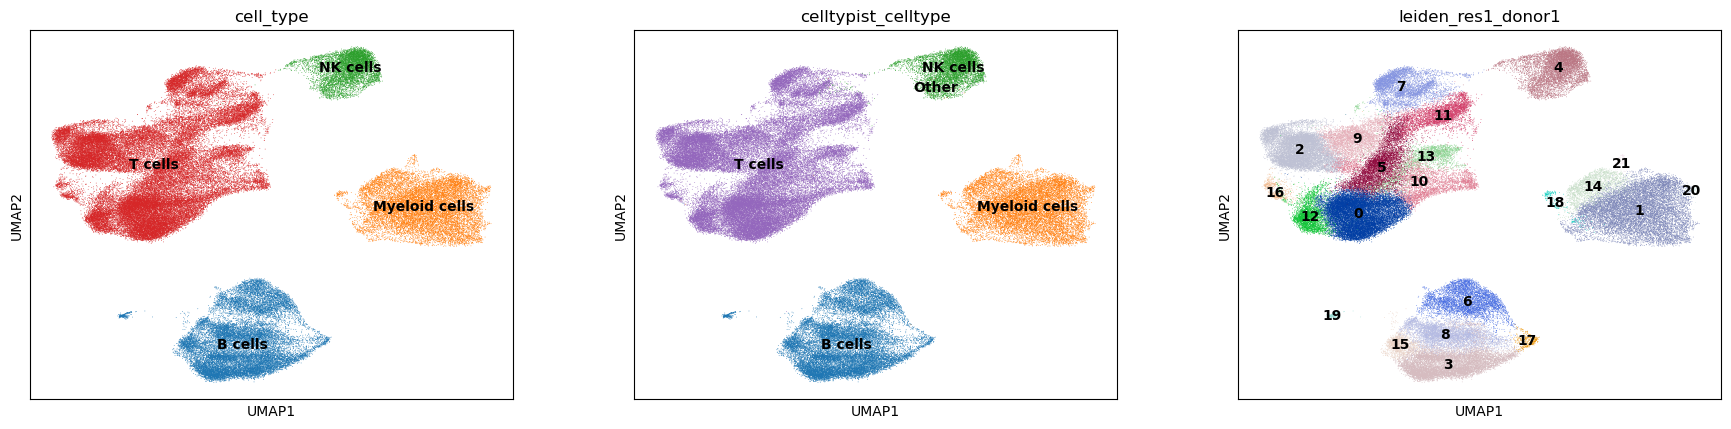

In [92]:
sc.pl.umap(sc_counts_hvg_donor1, color=['cell_type', "celltypist_celltype", "leiden_res1_donor1"], legend_loc="on data")

... storing 'celltypist_celltype' as categorical


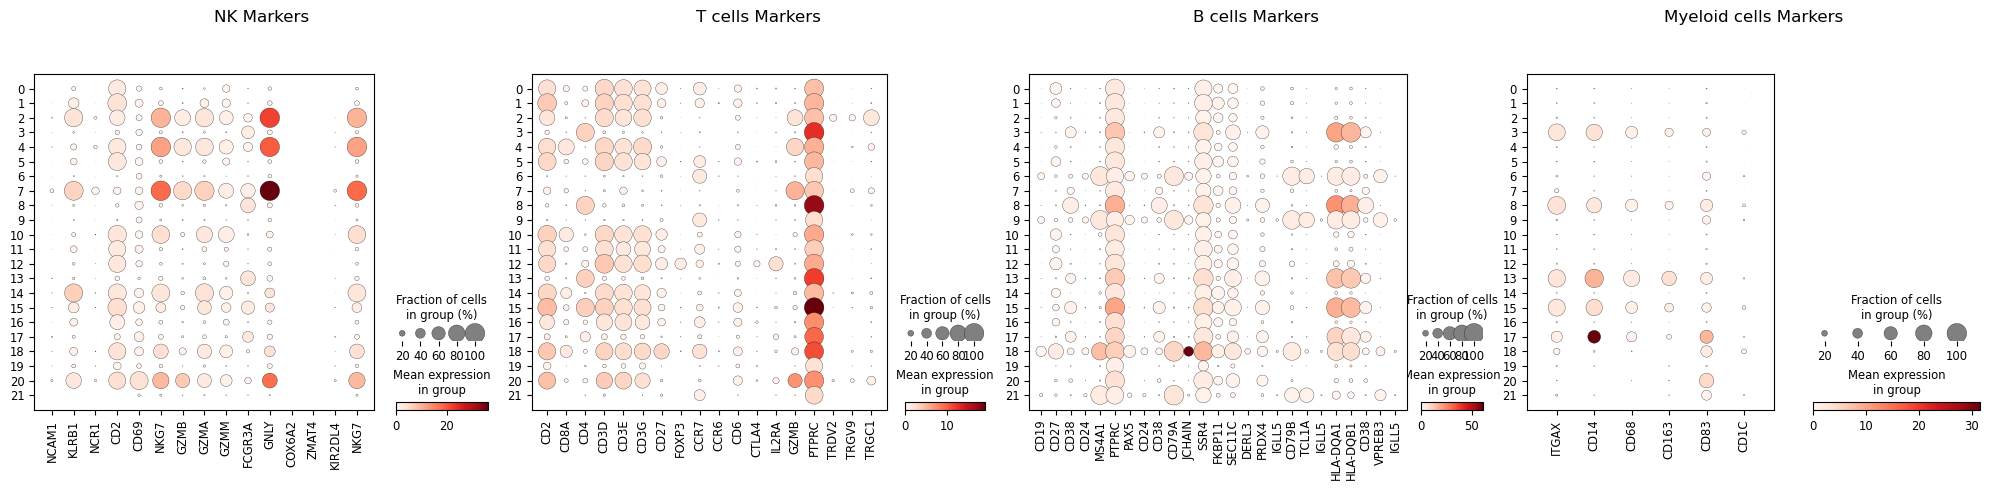

In [93]:
plot_marker_expression(sc_counts_hvg_donor2, markers_t_nk, "leiden_res1_donor2")

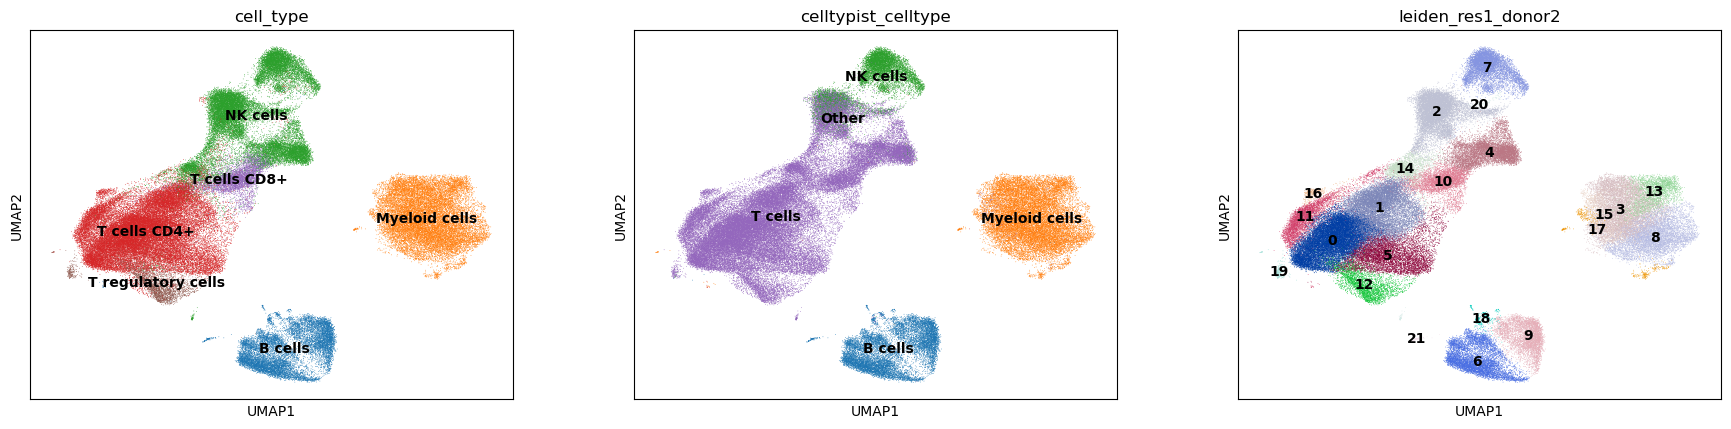

In [94]:
sc.pl.umap(sc_counts_hvg_donor2, color=['cell_type', "celltypist_celltype", "leiden_res1_donor2"], legend_loc="on data")

In [ ]:
# we take leiden clusters per donor as the ground truth
# for B cells, according to CD19 marker, 6, 9, 18, 21 are good candidates
# similarly MS4A1, CD79A, and PAX5

# for Myeloid cells, clusters 3, 8, 13, 15, 17 are good candidates
# especially due to ITGAX and CD68

# for NK cells, cluster 7 is a clear candidate due to NCAM1 and NCR1 expression
# cluster 2, 4, 20, 14 are candidates as well, but less clear

# 0, 1, 2, 4, 5, 10, 11, 12, 14, 15, 16, 18, 20 are all candidates for T ells, especially due to CD2, CD3D, CD3E, CD3G
# To differentiate between NK and T cells, we look into both celltypist  and original annotation proportions in the clusters for which we are uncertain

In [99]:
calculate_category_proportions(sc_counts_hvg_donor1, "20")

{'cell_type_proportions': cell_type
 Myeloid cells    1.0
 B cells          0.0
 NK cells         0.0
 T cells          0.0
 Name: count, dtype: float64,
 'celltypist_celltype_proportions': celltypist_celltype
 Myeloid cells    1.0
 B cells          0.0
 NK cells         0.0
 Other            0.0
 T cells          0.0
 Name: count, dtype: float64}

In [150]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor2, ["7"], donor=2).head(10)

sm_name  proportion
48  Dimethyl Sulfoxide    0.061429

In [151]:
find_sm_proportions_in_clusters(sc_counts_hvg_donor2, ["7"], donor=2).head(10)

sm_name  proportion
66                              IN1451    0.000000
12                           Alvocidib    0.000000
30                           CGP 60474    0.000000
138                    UNII-BXU45ZH6LI    0.006211
103  Proscillaridin A;Proscillaridin-A    0.028626
1                               ABT737    0.035144
44                           Dasatinib    0.035294
85                          Navitoclax    0.039387
113                       Ricolinostat    0.039432
72                        Ketoconazole    0.043860

In [149]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor2, ["7", "20"], donor=2).head(10)

sm_name  proportion
48  Dimethyl Sulfoxide    0.061524

In [153]:
find_sm_proportions_in_clusters(sc_counts_hvg_donor2, ["20"], donor=2)

sm_name  \
0    5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine   
91                                                             PD-0325901   
92                                                            PF-03814735   
93                                                            PF-04691502   
94                                                             PRT-062607   
..                                                                    ...   
44                                                              Dasatinib   
143                                                              YK 4-279   
48                                                     Dimethyl Sulfoxide   
50                                                              Dovitinib   
103                                     Proscillaridin A;Proscillaridin-A   

     proportion  
0      0.000000  
91     0.000000  
92     0.000000  
93     0.000000  
94     0.000000  
..          ...  
44     0.000000  
143    0.000000  
48     0.000095  
50     0.001992  
103    0.257634  

[144 rows x 2 columns]

In [157]:
sc_counts_hvg_donor2[sc_counts_hvg_donor2.obs.sm_name == "Proscillaridin A;Proscillaridin-A"].obs.leiden_res1_donor2.value_counts() / sc_counts_hvg_donor2[sc_counts_hvg_donor2.obs.sm_name == "Proscillaridin A;Proscillaridin-A"].shape[0]

leiden_res1_donor2
20    0.257634
17    0.166031
5     0.160305
6     0.099237
4     0.066794
9     0.059160
10    0.041985
0     0.036260
2     0.028626
7     0.028626
1     0.020992
14    0.019084
8     0.005725
12    0.005725
16    0.001908
18    0.001908
Name: count, dtype: float64

In [ ]:
# we take leiden clusters per donor as the ground truth
# for B cells, according to CD19 marker, 6, 9, 18, 21 are good candidates
# similarly MS4A1, CD79A, and PAX5

# for Myeloid cells, clusters 3, 8, 13, 15, 17 are good candidates
# especially due to ITGAX and CD68

# for NK cells, cluster 7 is a clear candidate due to NCAM1 and NCR1 expression
# cluster 2, 4, 20, 14 are candidates as well, but less clear

# 0, 1, 2, 4, 5, 10, 11, 12, 14, 15, 16, 18, 20 are all candidates for T ells, especially due to CD2, CD3D, CD3E, CD3G
# To differentiate between NK and T cells, we look into both celltypist  and original annotation proportions in the clusters for which we are uncertain

In [164]:
# cluster 19 contains outliers - not matching any of the 4 categories according to the markers listed above. We exclude it from the analysis
sc_counts_hvg_donor2 = sc_counts_hvg_donor2[sc_counts_hvg_donor2.obs.leiden_res1_donor2 != "19"]

In [165]:
leiden_to_celltype_map = {
    'B cells': ['6', '9', '18', '21'],  # Prioritizing clusters based on CD19, MS4A1, CD79A, and PAX5 as good candidates.
    'Myeloid cells': ['3', '8', '13', '15', '17'],  # Clusters identified strongly by ITGAX and CD68 markers.
    'NK cells': ['7'],  # Specifically requested to keep only cluster 7 for NK cells due to clear NCAM1 and NCR1 expression.
    'T cells': ['0', '1', '2', '4', '5', '10', '11', '12', '14', '15', '16', '20']  # Broad range of clusters identified by CD2, CD3D, CD3E, CD3G.
}

In [166]:
assign_cell_types_based_on_leiden(sc_counts_hvg_donor2, leiden_to_celltype_map, donor=2)

... storing 'cell_type' as categorical


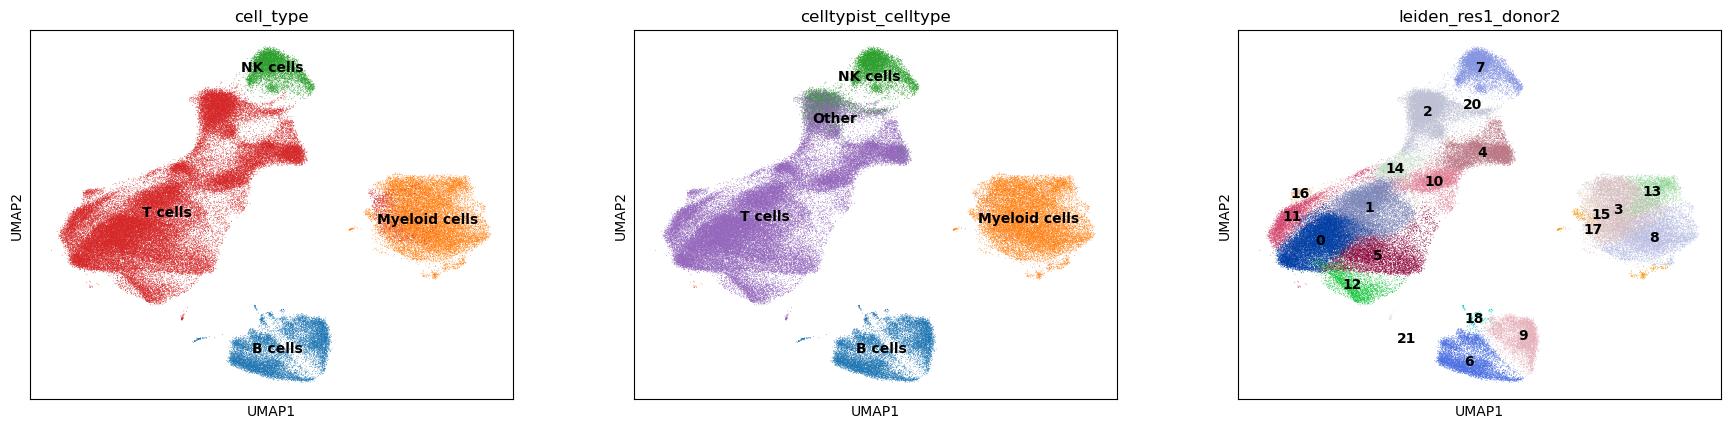

In [167]:
sc.pl.umap(sc_counts_hvg_donor2, color=['cell_type', "celltypist_celltype", "leiden_res1_donor2"], legend_loc="on data")

... storing 'celltypist_celltype' as categorical


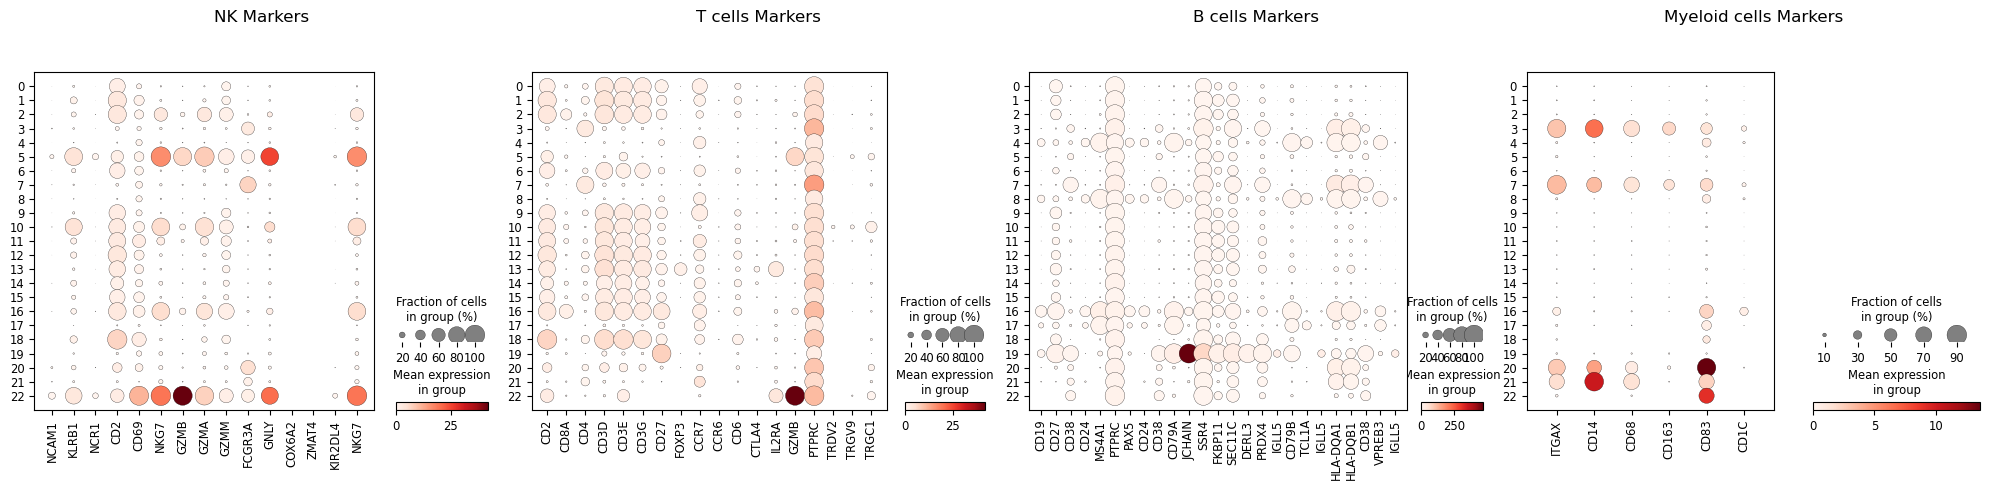

In [168]:
plot_marker_expression(sc_counts_hvg_donor3, markers_t_nk, "leiden_res1_donor3")

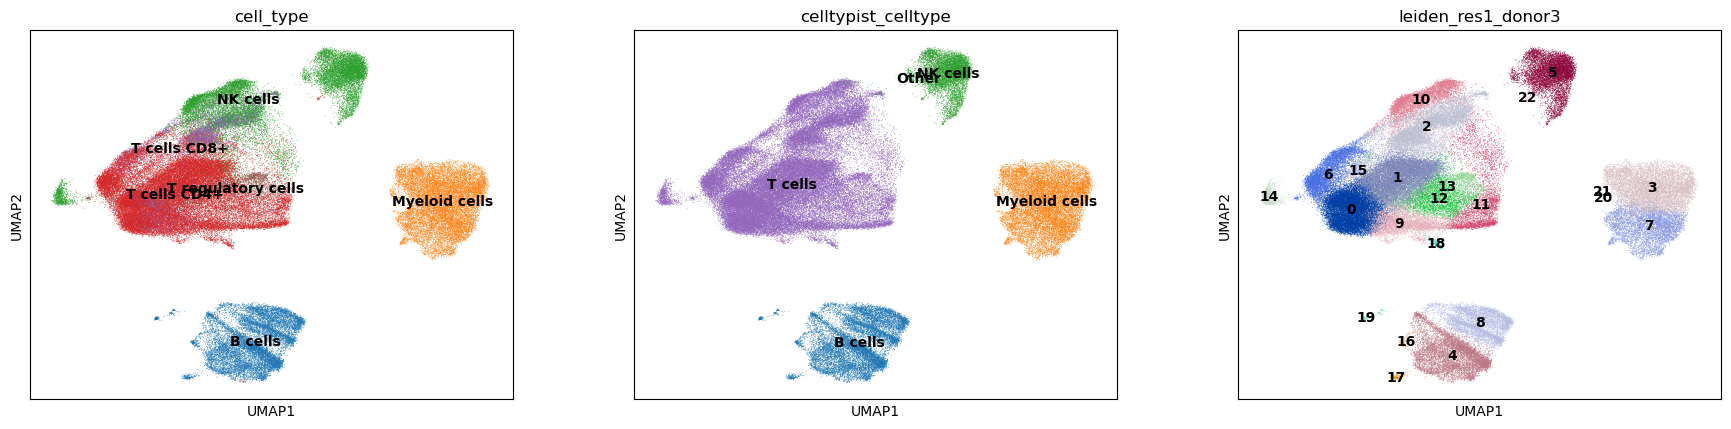

In [169]:
sc.pl.umap(sc_counts_hvg_donor3, color=['cell_type', "celltypist_celltype", "leiden_res1_donor3"], legend_loc="on data")

In [170]:
# we take leiden clusters per donor as the ground truth
# for B cells, according to CD19 marker, 4, 8, 16, 17, 19 are good candidates
# similarly MS4A1, CD79A, and PAX5

# for Myeloid cells, clusters 3, 7, 20, 21 are good candidates
# especially due to ITGAX and CD68

# for NK cells, clusters 5, 22 is a clear candidate due to NCAM1 and NCR1 expression

# 0, 1, 2, 6, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18 are all candidates for T ells, especially due to CD2, CD3D, CD3E, CD3G

In [183]:
find_dmso_proportions_in_clusters(sc_counts_hvg_donor3, ["5", "22"], donor=3).head(10)

sm_name  proportion
48  Dimethyl Sulfoxide    0.077955

In [188]:
leiden_to_celltype_map = {
    'B cells': ['4', '8', '16', '17', '19'],  # Clusters identified by markers CD19, MS4A1, CD79A, and PAX5.
    'Myeloid cells': ['3', '7', '20', '21'],  # Clusters highlighted by the expression of ITGAX and CD68.
    'NK cells': ['5', '22'],  # Clusters with clear expression of NCAM1 and NCR1.
    'T cells': ['0', '1', "2", '6', '9', '10', '11', '12', '13', '14', '15', '18']  # Extensive list of clusters based on CD2, CD3D, CD3E, CD3G.
}

In [189]:
assign_cell_types_based_on_leiden(sc_counts_hvg_donor3, leiden_to_celltype_map, donor=3)

... storing 'cell_type' as categorical


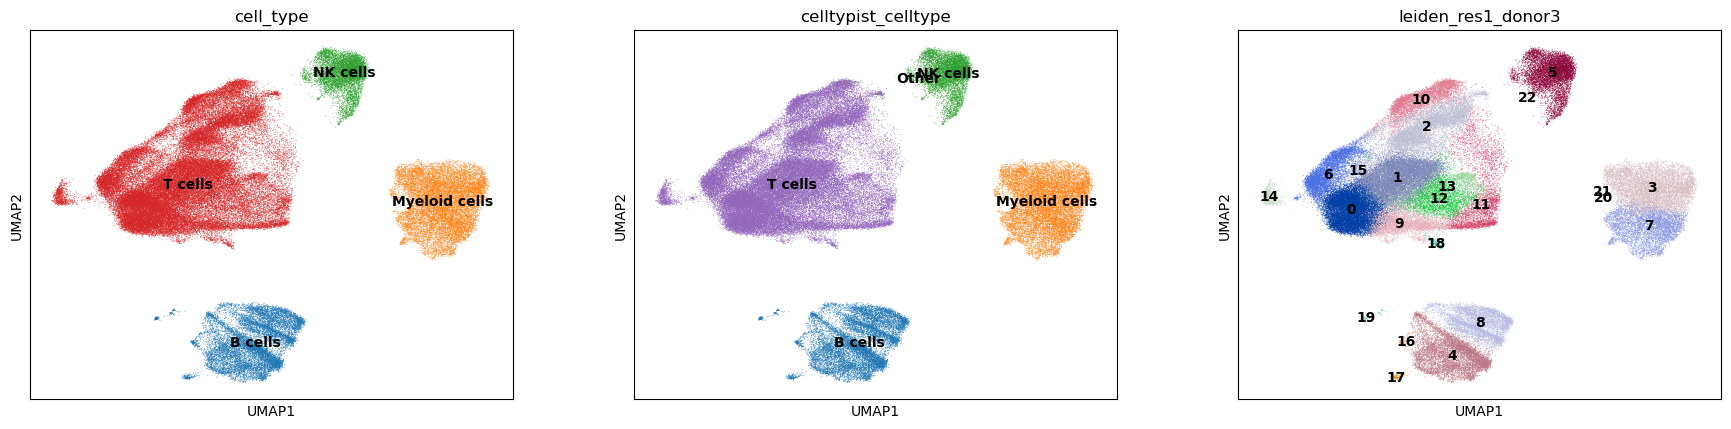

In [190]:
sc.pl.umap(sc.pl.umap(sc_counts_hvg_donor2, color=['cell_type', "celltypist_celltype", "leiden_res1_donor2"], legend_loc="on data"), color=['cell_type', "celltypist_celltype", "leiden_res1_donor3"], legend_loc="on data")

In [195]:
sc_counts.obs["cell_type_orig"] = sc_counts.obs["cell_type"]

In [211]:
sc_counts.obs["cell_type"] = pd.NA

In [212]:
combined_cell_types = {}

# Update the dictionary with cell_type from each subset
for subset in [sc_counts_hvg_donor1, sc_counts_hvg_donor2, sc_counts_hvg_donor3]:
    combined_cell_types.update(subset.obs['cell_type'].dropna().to_dict())

# Convert the dictionary to a Series
combined_cell_types_series = pd.Series(combined_cell_types)

# Map the combined series to sc_counts
sc_counts.obs['cell_type'] = sc_counts.obs.index.map(combined_cell_types_series)

In [217]:
# remove cells that have nan in cell_type
sc_counts = sc_counts[~sc_counts.obs.cell_type.isna()]

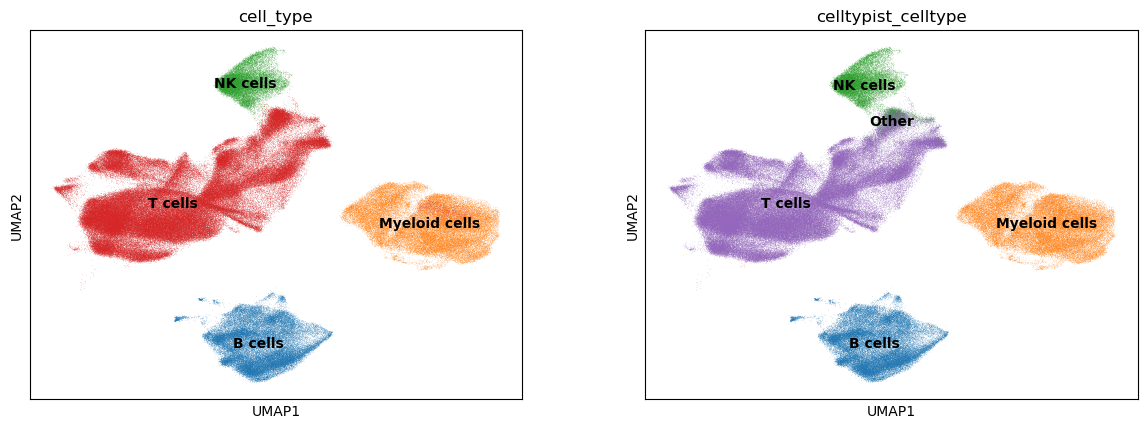

In [218]:
sc.pl.umap(sc_counts, color=['cell_type', "celltypist_celltype"], legend_loc="on data")

In [219]:
sc_counts.write_h5ad(f'{data_dir}/sc_counts_reannotated.h5ad')

In [12]:
from scipy import sparse
import numpy as np

In [13]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [20]:
bulk_adata_orig = sum_by(sc_counts, 'plate_well_cell_type')

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/1367489235.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  assert pd.api.types.is_categorical_dtype(adata.obs[col])


In [77]:
# plot proportions across wells of dmso
sc_counts.obs["plate_well_celltype_reannotated"] = sc_counts.obs["plate_name"].astype(str) + "_" + sc_counts.obs["well"].astype(str) + "_" + sc_counts.obs["cell_type"].astype(str)
sc_counts.obs["plate_well_celltype_reannotated"] = sc_counts.obs["plate_well_celltype_reannotated"].astype('category')
sc_counts.obs["plate_well_celltype_celltypist"] = sc_counts.obs["plate_name"].astype(str) + "_" + sc_counts.obs["well"].astype(str) + "_" + sc_counts.obs["celltypist_celltype"].astype(str)
sc_counts.obs["plate_well_celltype_celltypist"] = sc_counts.obs["plate_well_celltype_celltypist"].astype('category')

In [78]:
bulk_adata_reannotated = sum_by(sc_counts, 'plate_well_celltype_reannotated')
bulk_adata_celltypist = sum_by(sc_counts, 'plate_well_celltype_celltypist')
bulk_adata_celltypist.obs['cell_count'] = sc_counts.obs.groupby('plate_well_celltype_celltypist').size().values
bulk_adata_reannotated.obs['cell_count'] = sc_counts.obs.groupby('plate_well_celltype_reannotated').size().values

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/1367489235.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  assert pd.api.types.is_categorical_dtype(adata.obs[col])
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/1367489235.py:7: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  assert pd.api.types.is_categorical_dtype(adata.obs[col])
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2236759562.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_adata_celltypist.obs['cell_count'] = sc_counts.obs.groupby('plate_well_celltype_celltypist').size()

In [49]:
import matplotlib
import matplotlib.pyplot as plt
colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray', 'red']

In [30]:
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

In [41]:
bulk_adata_orig.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/3821759515.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_adata_orig.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values


In [89]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}

def compute_coefficient_of_variation(bulk_adata, compound_list, cell_type_col, plot=False):
    out_dict =  {}
    for i_control, control_compound in enumerate(compound_list):
        # subset and format data
        df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==control_compound]
        df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
        df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
        df_subset = df_subset[['plate_name_well', cell_type_col, "cell_count"]]
    
        # plot 
        cell_count_m = df_subset.pivot(index='plate_name_well', columns=cell_type_col, values='cell_count')
    
    
        cell_count_m['Total'] = cell_count_m.sum(axis=1)
        for column in cell_count_m.columns[:-1]:  # Exclude the Total column
            cell_count_m[column] = cell_count_m[column] / cell_count_m['Total']
        
        cell_count_m = cell_count_m.fillna(0)
        cell_count_m = cell_count_m.sort_values('Total')
        mean_proportions = cell_count_m.iloc[:, :-1].mean()
        std_proportions = cell_count_m.iloc[:, :-1].std()
        
        # Calculate coefficient of variation (CV)
        cv_proportions = std_proportions / mean_proportions
        cell_count_m = cell_count_m.drop(columns='Total')
        out_dict[control_compound] = cv_proportions
        if plot:
            plot_stacked_bar_chart(cell_count_m, title=control_compound, xticklabels=cell_count_m.index.values, colors=None, figsize=(15, 4))
    return pd.DataFrame(out_dict)

In [90]:
compute_coefficient_of_variation(bulk_adata_orig, controls3, "cell_type_orig")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

Dabrafenib  Belinostat  Dimethyl Sulfoxide
cell_type_orig                                                
B cells               0.319051    0.338520            0.307461
Myeloid cells         0.184550    0.275649            0.185540
NK cells              0.240455    0.577534            0.222283
T cells CD4+          0.129801    0.162064            0.106406
T cells CD8+          0.488251    2.288442            0.498569
T regulatory cells    0.411224    1.894598            0.317219

In [91]:
compute_coefficient_of_variation(bulk_adata_celltypist, controls3, "celltypist_celltype")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

Dabrafenib  Belinostat  Dimethyl Sulfoxide
celltypist_celltype                                            
B cells                0.320699    0.339472            0.308061
Myeloid cells          0.183917    0.273209            0.183943
NK cells               0.246820    0.286092            0.216222
Other                  2.206441    3.917784            2.392587
T cells                0.088988    0.103089            0.085498

In [92]:
compute_coefficient_of_variation(bulk_adata_reannotated, controls3, "cell_type")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

Dabrafenib  Belinostat  Dimethyl Sulfoxide
cell_type                                                
B cells          0.320012    0.338950            0.307860
Myeloid cells    0.173729    0.268931            0.166200
NK cells         0.215306    0.235822            0.211759
T cells          0.095927    0.103075            0.093332

In [ ]:
# we see that the cell type reannotated data has the lowest coefficient of variation across the wells

In [121]:
celltypist_cv = compute_coefficient_of_variation(bulk_adata_celltypist, bulk_adata_celltypist.obs.sm_name.unique().tolist(), "celltypist_celltype")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

In [101]:
orig_cv = compute_coefficient_of_variation(bulk_adata_orig, bulk_adata_orig.obs.sm_name.unique().tolist(), "cell_type_orig")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

In [102]:
reannotated_cv = compute_coefficient_of_variation(bulk_adata_reannotated, bulk_adata_reannotated.obs.sm_name.unique().tolist(), "cell_type")

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.plate_name = df_subset.plate_name.apply(lambda x: x.split("-")[1]).map(plate_name_map)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2083744915.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipy

In [107]:
orig_cv

TIE2 Kinase Inhibitor   MK-5108  Lapatinib  Belinostat  \
cell_type_orig                                                               
B cells                          0.494450  0.393188   0.438719    0.338520   
Myeloid cells                    0.209962  0.134386   0.223354    0.275649   
NK cells                         0.247062  0.198460   0.306088    0.577534   
T cells CD4+                     0.126643  0.049344   0.167683    0.162064   
T cells CD8+                     0.230734  0.146743   0.438934    2.288442   
T regulatory cells               0.420655  0.092132   0.096745    1.894598   

                    Dabrafenib  Dimethyl Sulfoxide  Atorvastatin  \
cell_type_orig                                                     
B cells               0.319051            0.307461      0.474942   
Myeloid cells         0.184550            0.185540      0.232784   
NK cells              0.240455            0.222283      0.211277   
T cells CD4+          0.129801            0.106406      0.034913   
T cells CD8+          0.488251            0.498569      0.361447   
T regulatory cells    0.411224            0.317219      0.278679   

                    Ganetespib (STA-9090)  Clomipramine  Sunitinib  ...  \
cell_type_orig                                                      ...   
B cells                          0.434919      0.169616   0.297148  ...   
Myeloid cells                    1.037824      0.071548   0.341602  ...   
NK cells                         1.088000      0.209459   0.125553  ...   
T cells CD4+                     0.856408      0.013710   0.165043  ...   
T cells CD8+                     1.732051      0.343942   0.327203  ...   
T regulatory cells               0.880717      0.222927   0.204318  ...   

                    Prednisolone  Tacalcitol  Selumetinib  Clotrimazole  \
cell_type_orig                                                            
B cells                 0.519925    0.378798     0.512159      0.421404   
Myeloid cells           0.104697    0.226540     0.455037      0.156284   
NK cells                0.335479    0.313638     0.292682      0.220418   
T cells CD4+            0.019240    0.175907     0.137812      0.065876   
T cells CD8+            0.285554    0.682429     0.647765      0.600449   
T regulatory cells      0.453840    0.237347     0.213631      0.191865   

                      RG7090  GLPG0634  Mubritinib (TAK 165)  Vanoxerine  \
cell_type_orig                                                             
B cells             0.599784  0.452266              0.445328    0.431822   
Myeloid cells       0.315301  0.114449              0.231037    0.244765   
NK cells            0.207202  0.319252              0.314879    0.262863   
T cells CD4+        0.249204  0.082844              0.147762    0.186808   
T cells CD8+        0.858077  0.693631              0.508699    0.464684   
T regulatory cells  0.258207  0.436936              0.223069    0.327814   

                    SB525334  HYDROXYUREA  
cell_type_orig                             
B cells             0.507351     0.622500  
Myeloid cells       0.340607     0.020092  
NK cells            0.153332     0.430020  
T cells CD4+        0.226653     0.065028  
T cells CD8+        0.366950     0.329475  
T regulatory cells  0.165643     0.141551  

[6 rows x 144 columns]

In [123]:
orig_cv.mean(axis=1)

cell_type_orig
B cells               0.399447
Myeloid cells         0.280278
NK cells              0.304085
T cells CD4+          0.169593
T cells CD8+          0.591442
T regulatory cells    0.392859
dtype: float64

In [124]:
reannotated_cv.mean(axis=1)

cell_type
B cells          0.402630
Myeloid cells    0.273896
NK cells         0.230847
T cells          0.107045
dtype: float64

In [106]:
reannotated_cv

TIE2 Kinase Inhibitor   MK-5108  Lapatinib  Belinostat  \
cell_type                                                               
B cells                     0.494450  0.393188   0.438719    0.338950   
Myeloid cells               0.178837  0.121343   0.230787    0.268931   
NK cells                    0.107720  0.308855   0.121503    0.235822   
T cells                     0.099452  0.146180   0.156103    0.103075   

               Dabrafenib  Dimethyl Sulfoxide  Atorvastatin  \
cell_type                                                     
B cells          0.320012            0.307860      0.474942   
Myeloid cells    0.173729            0.166200      0.220394   
NK cells         0.215306            0.211759      0.103562   
T cells          0.095927            0.093332      0.078792   

               Ganetespib (STA-9090)  Clomipramine  Sunitinib  ...  \
cell_type                                                      ...   
B cells                     0.438586      0.169616   0.297148  ...   
Myeloid cells               1.037824      0.098416   0.314391  ...   
NK cells                    0.240057      0.158032   0.234640  ...   
T cells                     0.104515      0.057253   0.088514  ...   

               Prednisolone  Tacalcitol  Selumetinib  Clotrimazole    RG7090  \
cell_type                                                                      
B cells            0.522444    0.378798     0.515558      0.432360  0.604318   
Myeloid cells      0.146853    0.206410     0.417738      0.100320  0.246111   
NK cells           0.327838    0.104777     0.155804      0.130298  0.220644   
T cells            0.135402    0.099610     0.110244      0.108779  0.150949   

               GLPG0634  Mubritinib (TAK 165)  Vanoxerine  SB525334  \
cell_type                                                             
B cells        0.452266              0.452696    0.431822  0.511323   
Myeloid cells  0.092121              0.176795    0.197596  0.271446   
NK cells       0.253832              0.159928    0.192676  0.298676   
T cells        0.125573              0.062991    0.167382  0.163876   

               HYDROXYUREA  
cell_type                   
B cells           0.622500  
Myeloid cells     0.065528  
NK cells          0.120124  
T cells           0.155932  

[4 rows x 144 columns]

In [110]:
(reannotated_cv - orig_cv).fillna(0).mean(axis=1)

B cells               0.003183
Myeloid cells        -0.016420
NK cells             -0.073238
T cells               0.000000
T cells CD4+          0.000000
T cells CD8+          0.000000
T regulatory cells    0.000000
dtype: float64

In [122]:
(reannotated_cv - celltypist_cv).fillna(0).mean(axis=1)

B cells          0.002046
Myeloid cells   -0.012846
NK cells        -0.017699
Other            0.000000
T cells          0.011295
dtype: float64

In [111]:
# overall the reannotated data has lower coefficient of variation for the NK cells and Myeloid cells

In [130]:
def identify_outliers(celltype_subset):
    Q1 = celltype_subset.quantile(0.25)
    Q3 = celltype_subset.quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Determine upper whisker cutoff
    upper_whisker = Q3 + 1.5 * IQR
    
    # Identify outliers
    return celltype_subset[celltype_subset > upper_whisker].sort_values()

In [131]:
identify_outliers(reannotated_cv.loc["NK cells"])

R428               0.475982
ABT737             0.499106
Navitoclax         0.633938
IN1451             0.866352
CGP 60474          1.331005
UNII-BXU45ZH6LI    1.596482
Alvocidib          1.732051
Name: NK cells, dtype: float64

In [132]:
identify_outliers(reannotated_cv.loc["T cells"])

IN1451             0.405778
UNII-BXU45ZH6LI    0.475872
Name: T cells, dtype: float64

In [134]:
identify_outliers(reannotated_cv.loc["Myeloid cells"])

Tamatinib                            0.601744
Foretinib                            0.776324
Proscillaridin A;Proscillaridin-A    0.795609
Canertinib                           0.822061
Ganetespib (STA-9090)                1.037824
IN1451                               1.069821
PF-04691502                          1.289421
UNII-BXU45ZH6LI                      1.607224
BMS-387032                           1.732051
Alvocidib                            1.732051
Name: Myeloid cells, dtype: float64

In [135]:
identify_outliers(reannotated_cv.loc["B cells"])

Palbociclib    0.651235
Alvocidib      0.951744
BMS-387032     0.976339
CGP 60474      1.463202
Name: B cells, dtype: float64

In [144]:
# set of all the outlier compounds according to the coefficient of variation
outlier_compounds_cv = set(identify_outliers(reannotated_cv.loc["NK cells"]).index.tolist()).union(identify_outliers(reannotated_cv.loc["T cells"]).index.tolist()).union(identify_outliers(reannotated_cv.loc["Myeloid cells"]).index.tolist()).union(identify_outliers(reannotated_cv.loc["B cells"]).index.tolist())

In [145]:
outlier_compounds_cv

{'ABT737',
 'Alvocidib',
 'BMS-387032',
 'CGP 60474',
 'Canertinib',
 'Foretinib',
 'Ganetespib (STA-9090)',
 'IN1451',
 'Navitoclax',
 'PF-04691502',
 'Palbociclib',
 'Proscillaridin A;Proscillaridin-A',
 'R428',
 'Tamatinib',
 'UNII-BXU45ZH6LI'}

In [148]:
bulk_adata_reannotated[bulk_adata_reannotated.obs.sm_name.isin(outlier_compounds_cv)].obs

plate_well_celltype_reannotated      cell_type donor_id  timepoint_hr  \
28           NeurIPS2023-010_A5_B cells        B cells  Donor 1          24.0   
29     NeurIPS2023-010_A5_Myeloid cells  Myeloid cells  Donor 1          24.0   
30          NeurIPS2023-010_A5_NK cells       NK cells  Donor 1          24.0   
31           NeurIPS2023-010_A5_T cells        T cells  Donor 1          24.0   
44           NeurIPS2023-010_A9_B cells        B cells  Donor 1          24.0   
...                                 ...            ...      ...           ...   
2006         NeurIPS2023-015_C6_T cells        T cells  Donor 3          24.0   
2111        NeurIPS2023-015_F10_B cells        B cells  Donor 3          24.0   
2112  NeurIPS2023-015_F10_Myeloid cells  Myeloid cells  Donor 3          24.0   
2113       NeurIPS2023-015_F10_NK cells       NK cells  Donor 3          24.0   
2114        NeurIPS2023-015_F10_T cells        T cells  Donor 3          24.0   

      is_dmso                                             SMILES sm_lincs_id  \
28      False  CC(C)c1cc(-c2n[nH]c(=O)n2-c2ccc3c(ccn3C)c2)c(O...   LSM-45281   
29      False  CC(C)c1cc(-c2n[nH]c(=O)n2-c2ccc3c(ccn3C)c2)c(O...   LSM-45281   
30      False  CC(C)c1cc(-c2n[nH]c(=O)n2-c2ccc3c(ccn3C)c2)c(O...   LSM-45281   
31      False  CC(C)c1cc(-c2n[nH]c(=O)n2-c2ccc3c(ccn3C)c2)c(O...   LSM-45281   
44      False  COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)...    LSM-1040   
...       ...                                                ...         ...   
2006    False  CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...    LSM-1180   
2111    False  Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1c...   LSM-45574   
2112    False  Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1c...   LSM-45574   
2113    False  Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1c...   LSM-45574   
2114    False  Nc1nc(Nc2ccc3c(c2)CC[C@@H](N2CCCC2)CC3)nn1-c1c...   LSM-45574   

     well       plate_name  col cell_id  control row                sm_name  \
28     A5  NeurIPS2023-010    5    PBMC    False   A  Ganetespib (STA-9090)   
29     A5  NeurIPS2023-010    5    PBMC    False   A  Ganetespib (STA-9090)   
30     A5  NeurIPS2023-010    5    PBMC    False   A  Ganetespib (STA-9090)   
31     A5  NeurIPS2023-010    5    PBMC    False   A  Ganetespib (STA-9090)   
44     A9  NeurIPS2023-010    9    PBMC    False   A              Tamatinib   
...   ...              ...  ...     ...      ...  ..                    ...   
2006   C6  NeurIPS2023-015    6    PBMC    False   C                 ABT737   
2111  F10  NeurIPS2023-015   10    PBMC    False   F                   R428   
2112  F10  NeurIPS2023-015   10    PBMC    False   F                   R428   
2113  F10  NeurIPS2023-015   10    PBMC    False   F                   R428   
2114  F10  NeurIPS2023-015   10    PBMC    False   F                   R428   

      dose_uM         library_id  cell_count  
28        1.0  NeurIPS2023-010_A         106  
29        1.0  NeurIPS2023-010_A           6  
30        1.0  NeurIPS2023-010_A          34  
31        1.0  NeurIPS2023-010_A         310  
44        1.0  NeurIPS2023-010_A         120  
...       ...                ...         ...  
2006      1.0  NeurIPS2023-015_C         241  
2111      1.0  NeurIPS2023-015_F          56  
2112      1.0  NeurIPS2023-015_F          72  
2113      1.0  NeurIPS2023-015_F          33  
2114      1.0  NeurIPS2023-015_F         286  

[163 rows x 17 columns]

<Axes: >

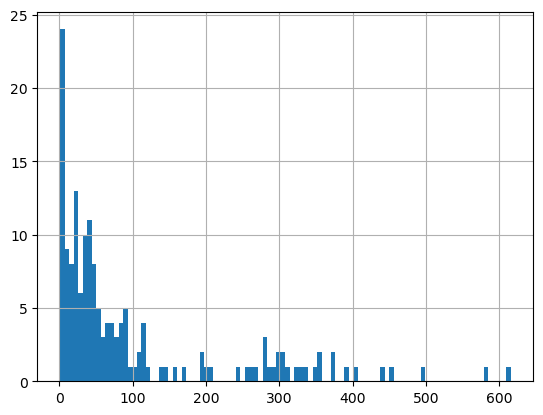

In [154]:
bulk_adata_reannotated[bulk_adata_reannotated.obs.sm_name.isin(outlier_compounds_cv)].obs.cell_count.hist(bins=100)

<Axes: >

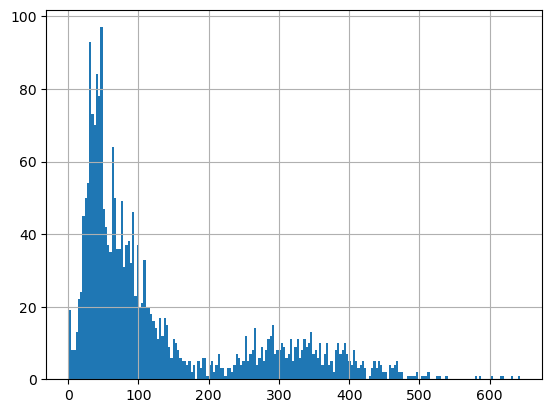

In [155]:
bulk_adata_reannotated.obs.cell_count.hist(bins=200)

<Axes: >

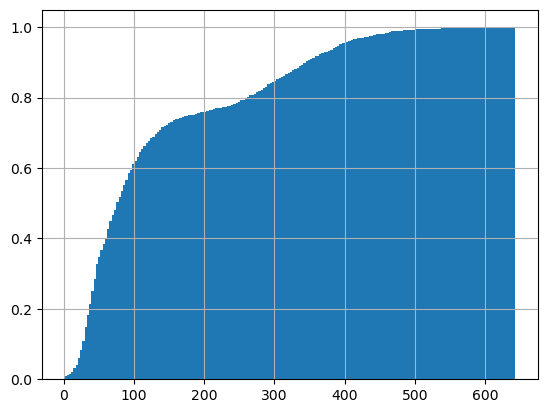

In [159]:
# plot cdf of cell counts per well
bulk_adata_reannotated.obs.cell_count.hist(bins=200, cumulative=True, density=True)

In [174]:
compounds_under_10 = set(bulk_adata_reannotated[bulk_adata_reannotated.obs.cell_count < 10].obs.sm_name.unique().tolist())

In [176]:
len(outlier_compounds_cv.intersection(compounds_under_10))

10

In [177]:
len(outlier_compounds_cv.difference(compounds_under_10))

5

In [178]:
outlier_compounds_cv.difference(compounds_under_10)

{'Canertinib',
 'Foretinib',
 'Palbociclib',
 'Proscillaridin A;Proscillaridin-A',
 'R428'}

In [164]:
# add to each cell indication of how many cells of the cell type are in its well
sc_counts.obs['cell_count_by_well_celltype'] = sc_counts.obs.groupby('plate_well_celltype_reannotated')['plate_well_celltype_reannotated'].transform('size')

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/2874714785.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_counts.obs['cell_count'] = sc_counts.obs.groupby('plate_well_celltype_reannotated')['plate_well_celltype_reannotated'].transform('size')


In [179]:
sc_counts.obs["plate_well"] = sc_counts.obs["plate_name"].astype(str) + "_" + sc_counts.obs["well"].astype(str)
sc_counts.obs["plate_well"] = sc_counts.obs["plate_well"].astype('category')
sc_counts.obs['cell_count_by_plate_well'] = sc_counts.obs.groupby('plate_well')['plate_well'].transform('size')

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_54797/1584134677.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc_counts.obs['cell_count_by_plate_well'] = sc_counts.obs.groupby('plate_well')['plate_well'].transform('size')


In [ ]:
sc_counts.obs = sc_counts.obs.drop(columns=["plate_well_celltype_celltypist", "plate_well", "celltypist_celltype", "is_t", "is_dmso", "plate_well_cell_type"])

In [ ]:
sc_counts.write_h5ad(f'{data_dir}/sc_counts_reannotated_with_counts.h5ad', compression="gzip")